In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.patches as patches
from PIL import Image
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load dataset

In [ ]:

faces = pd.read_csv('/content/drive/MyDrive/CS216 Files/HW2/Face Data/faces.csv')
image_dir = '/content/drive/MyDrive/CS216 Files/HW2/Face Data/images'

# Visualize data

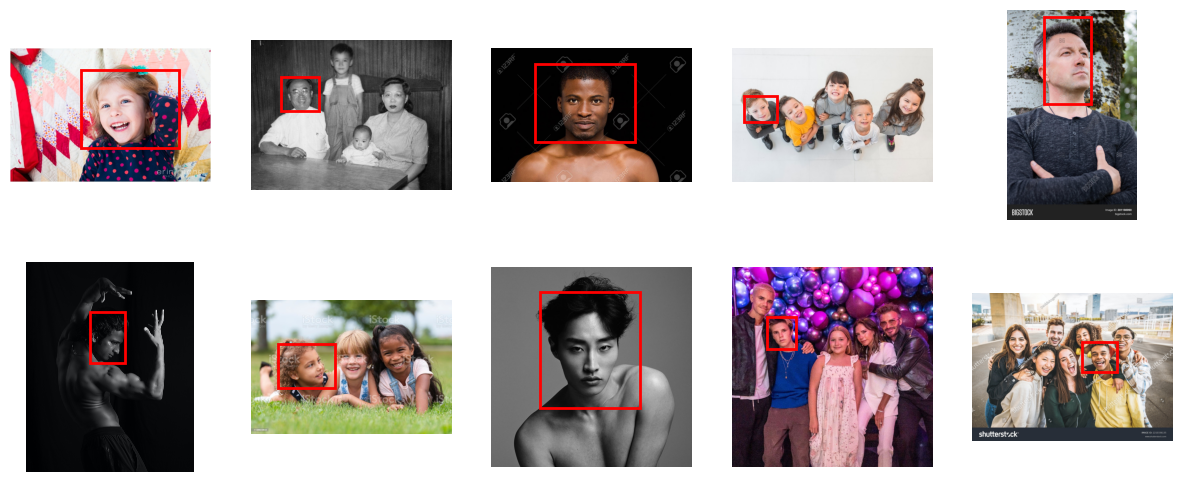

In [ ]:
#@title
sample_images = faces.sample(n=10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), sample_images.iterrows()):
    image_path = os.path.join(image_dir, row['image_name'])
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')

    x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
    bbox = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(bbox)

plt.show()

# Generate negative samples (random patches from the image that are not faces) and Train the models


In [ ]:
def generate_negative_samples(data, img_dir, num_samples=500):
    features = []
    labels = []
    for _, row in data.iterrows():
        img_path = os.path.join(img_dir, row['image_name'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Extract positive face sample
            face = img[int(row['y0']):int(row['y1']), int(row['x0']):int(row['x1'])]
            face_resized = cv2.resize(face, (64, 64)).flatten()
            features.append(face_resized)
            labels.append(1)  # Face

            # Generate a random background patch as a negative sample
            for _ in range(2):  # Add multiple background samples per face
                h, w = img.shape
                x0, y0 = np.random.randint(0, w - 64), np.random.randint(0, h - 64)
                if x0 > row['x1'] or y0 > row['y1']:  # Ensure it's not overlapping the face
                    background = img[y0:y0+64, x0:x0+64]
                    background_resized = cv2.resize(background, (64, 64)).flatten()
                    features.append(background_resized)
                    labels.append(0)  # Background

    features = np.array(features)
    labels = np.array(labels)
    return features, labels

# Prepare features and labels
X, y = generate_negative_samples(faces, image_dir)

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Train SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC(kernel='linear', probability=True)

# Function to apply Non-Maximum Suppression (NMS) based on IoU

In [ ]:
def non_max_suppression(boxes, scores, threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]  # Sort scores in descending order

    keep = []
    while order.size > 0:
        i = order[0]  # Pick the highest score box
        keep.append(i)

        # Compute IoU with other boxes
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        inter = w * h

        iou = inter / (areas[i] + areas[order[1:]] - inter)
        order = order[np.where(iou <= threshold)[0] + 1]  # Keep boxes with IoU below threshold

    return keep

# Function to detect faces in an image
def detect_faces(img_path, model, threshold=0.5):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape

    step_size = 32  # Sliding window step size
    window_size = 64  # Detection window size
    detected_boxes = []
    scores = []

    for y in range(0, h - window_size, step_size):
        for x in range(0, w - window_size, step_size):
            patch = img[y:y + window_size, x:x + window_size]
            patch_resized = cv2.resize(patch, (64, 64)).flatten().reshape(1, -1)
            score = model.predict_proba(patch_resized)[0][1]  # Face probability

            if score > threshold:
                detected_boxes.append([x, y, x + window_size, y + window_size])
                scores.append(score)

    # Apply NMS to remove overlapping detections
    keep_indices = non_max_suppression(detected_boxes, scores, threshold=0.3)
    final_boxes = [detected_boxes[i] for i in keep_indices]

    return final_boxes



# Testing SVM model

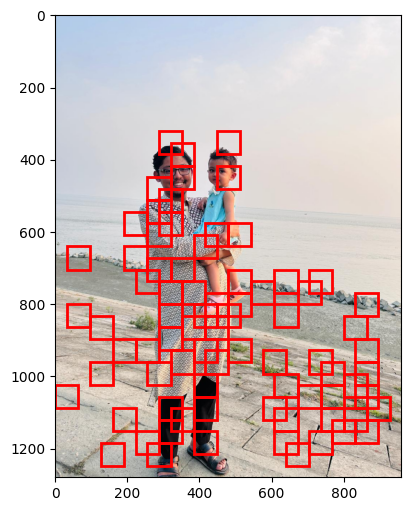

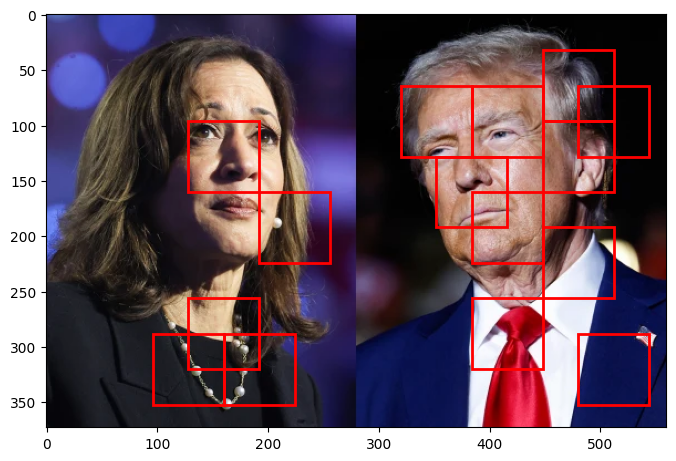

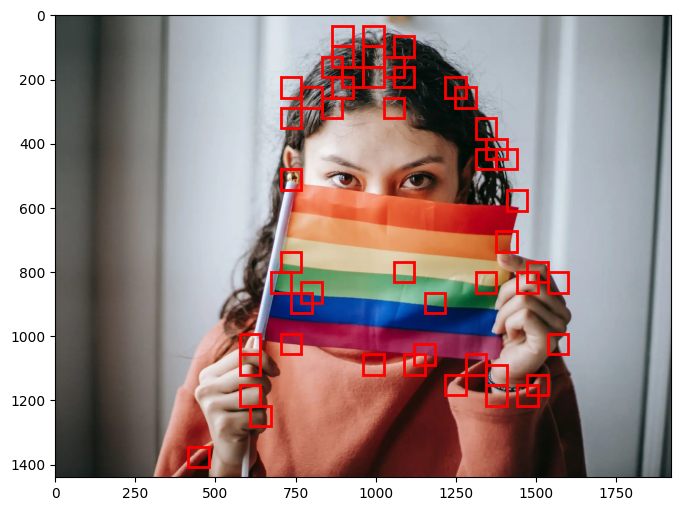

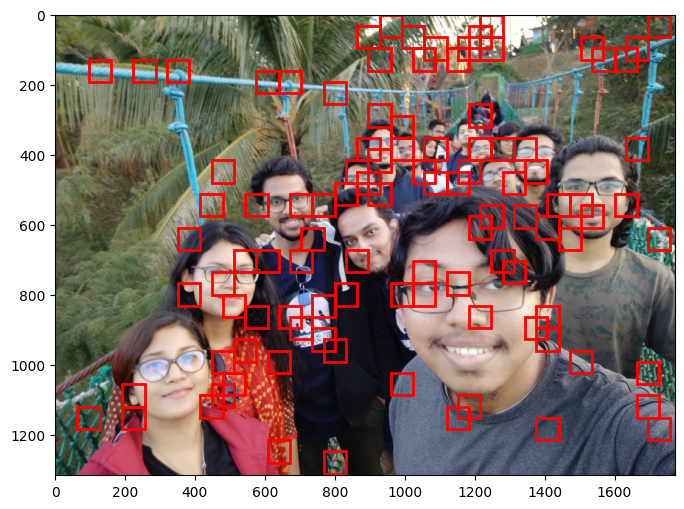

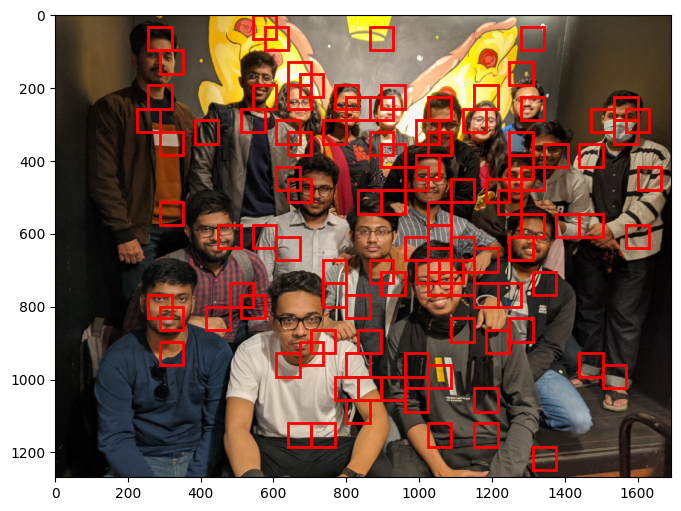

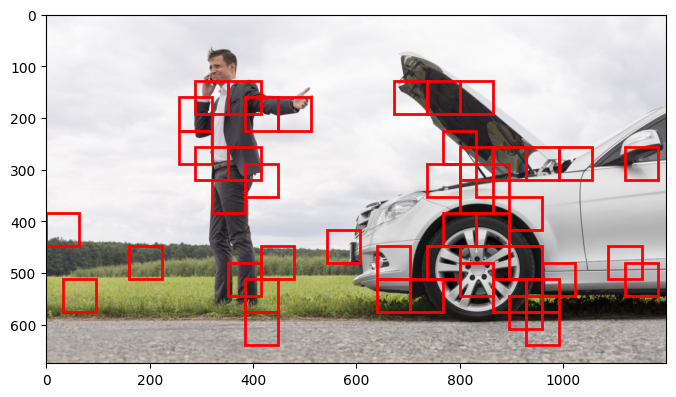

In [ ]:
#@title
test_dir = "/content/drive/MyDrive/CS216 Files/HW2/Test Images"

for filename in os.listdir(test_dir):
    test_image_path = os.path.join(test_dir, filename)
    detected_faces = detect_faces(test_image_path, svm_model)

    # Plot detection results
    img = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    for box in detected_faces:
        x0, y0, x1, y1 = box
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()



# Testing Logistic Regression

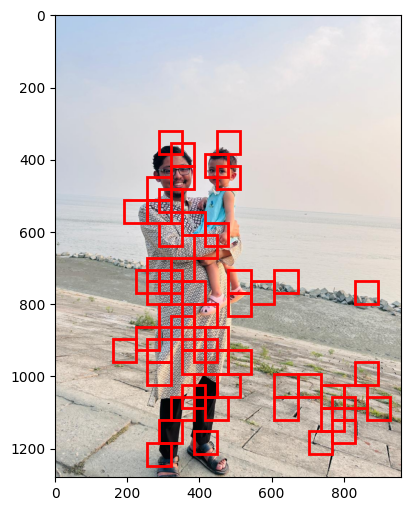

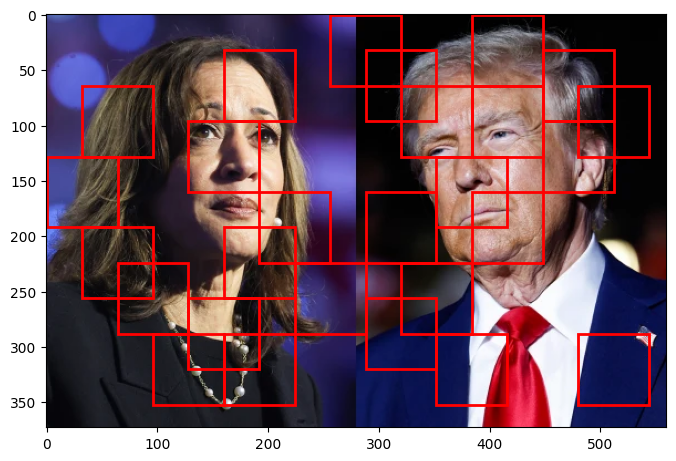

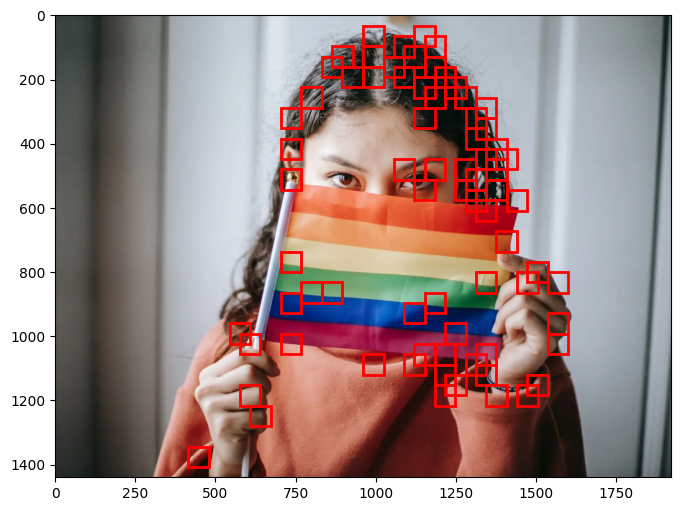

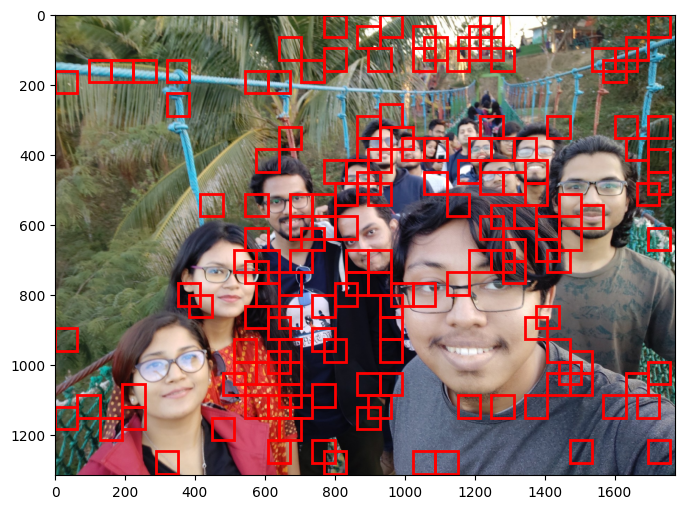

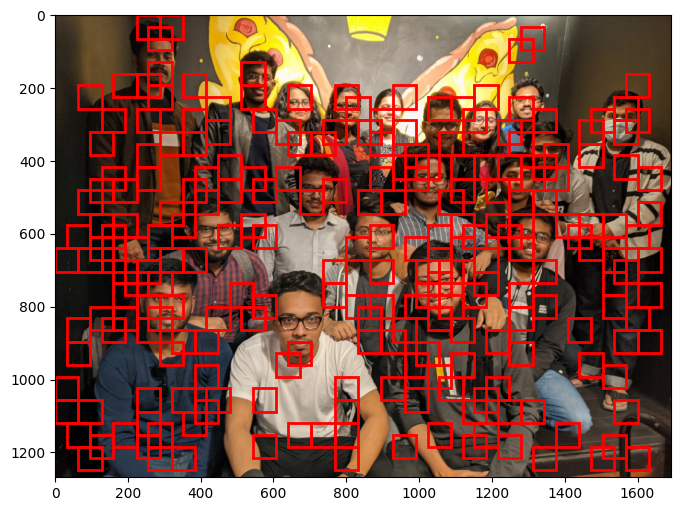

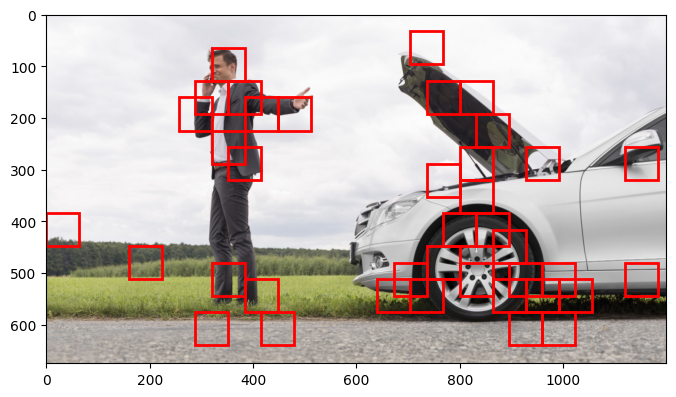

In [ ]:
#@title
test_dir = "/content/drive/MyDrive/CS216 Files/HW2/Test Images"

for filename in os.listdir(test_dir):
    test_image_path = os.path.join(test_dir, filename)
    detected_faces = detect_faces(test_image_path, logistic_model)

    # Plot detection results
    img = cv2.imread(test_image_path, cv2.IMREAD_COLOR)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    for box in detected_faces:
        x0, y0, x1, y1 = box
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()



It seems that linear classifier performs very poor in face detection or any object detection task from an image